In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
PATH = './vit_net.pth'

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

train, val = torch.utils.data.random_split(trainset, [48000, 2000])
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class MultiheadAttention(nn.Module):
  def __init__(self, in_features, num_heads=3, attn_drop=0.1, proj_drop=0.1, qkv_bias=True):
    super().__init__()
    self.in_features = in_features
    self.num_heads = num_heads
    self.attn_height = self.in_features // self.num_heads
    self.qkv = nn.Linear(self.in_features, self.in_features * 3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(attn_drop)
    self.proj = nn.Linear(self.in_features, self.in_features)
    self.proj_drop = nn.Dropout(proj_drop)

  def forward(self, x):
    batch_size, seq_len, _ = x.shape # [64, 65, 192] -> [64, 65, 576] -> [64, 65, 3, 3, 64]
    qkv = self.qkv(x).reshape(batch_size, seq_len, 3, self.num_heads, self.attn_height).permute(2, 0, 3, 1, 4) # [3, 64, 3, 65, 64]
    q, k, v = qkv.unbind(0) # [64, 3, 65, 64]

    k = k.transpose(-2, -1) # [64, 3, 64, 65]
    attn = torch.matmul(q, k) # [64, 3, 65, 65]
    attn = attn * (self.attn_height ** -0.5)
    attn = self.attn_drop(F.softmax(attn, dim=-1))

    out = torch.matmul(attn, v) # [64, 3, 65, 64]
    out = out.permute(0, 2, 1, 3) # [64, 65, 3, 64]
    out = out.flatten(2) # [64, 65, 192]

    out = self.proj(out) 
    out = self.proj_drop(out)
    return out

In [4]:
class EncoderBlock(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.ln1 = nn.LayerNorm(in_features)
    self.msa = MultiheadAttention(in_features)
    self.dropout = nn.Dropout(0.1)
    self.ln2 = nn.LayerNorm(in_features)
    self.mlp = nn.Sequential(
        nn.Linear(in_features, 4 * in_features),
        nn.GELU(),
        nn.Dropout(0.1),
        nn.Linear(4 * in_features, in_features),
        nn.Dropout(0.1))

  def forward(self, x):
    residual = x
    x = self.dropout(self.msa(self.ln1(x)))
    x = residual + x
    residual = x
    x = self.mlp(self.ln2(x))
    x = residual + x
    return x

In [5]:
class Encoder(nn.Module):
  def __init__(self, in_features, num_blocks):
    super().__init__()
    self.dropout = nn.Dropout(0.1)
    self.layers = nn.Sequential(*[EncoderBlock(in_features) for _ in range(num_blocks)])
    self.ln = nn.LayerNorm(in_features)

  def forward(self, x):
    x = self.ln(self.layers(self.dropout(x)))
    return x

In [6]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_proj = nn.Conv2d(3, 192, 4, stride=4)
    self.class_token = nn.Parameter(torch.rand(1, 1, 192))
    self.pos_embed = nn.Parameter(torch.rand(1, 65, 192))
    self.encoder = Encoder(192, 12)
    self.head = nn.Linear(192, 10)
  
  def forward(self, x):
    x = self.conv_proj(x) # [64, 3, 32, 32] -> [64, 192, 8, 8]
    x = x.flatten(2) # [64, 192, 64]
    x = x.permute((0, 2, 1)) # [64, 64, 192]
    class_token = self.class_token.repeat(x.shape[0], 1, 1)
    x = torch.cat([class_token, x], dim=1) # [64, 65, 192]
    pos_embed = self.pos_embed.repeat(x.shape[0], 1, 1)
    x = x + pos_embed
    x = self.encoder(x)
    x = x[:,0,:] # [64, 1, 192]
    x = torch.flatten(x, 1) # [64, 192]
    x = self.head(x)
    return x

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
net = VisionTransformer()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_losses, val_losses = [], []
lowest_val_loss = np.inf

In [9]:
net = net.train()

for epoch in range(32):
    epoch_train_losses, epoch_val_losses = [], []
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        pred = net(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.detach().cpu().numpy())
    
    correct = 0
    total = 0
    for x, y in valloader:
        x, y = x.to(device), y.to(device)
        pred = net(x)
        loss = criterion(pred, y)
        epoch_val_losses.append(loss.detach().cpu().numpy())

        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    avg_train_loss = np.mean(epoch_train_losses)
    avg_val_loss = np.mean(epoch_val_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f'Epoch: {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct // total} %')
    if avg_val_loss < lowest_val_loss:
      lowest_val_loss = avg_val_loss
      torch.save(net.state_dict(), PATH)
            
print('Finished Training')

Epoch: 0, Training Loss: 1.8356322050094604, Validation Loss: 1.6874473094940186, Validation Accuracy: 36 %
Epoch: 1, Training Loss: 1.6338597536087036, Validation Loss: 1.638653039932251, Validation Accuracy: 38 %
Epoch: 2, Training Loss: 1.5379019975662231, Validation Loss: 1.5449739694595337, Validation Accuracy: 43 %
Epoch: 3, Training Loss: 1.5184500217437744, Validation Loss: 1.496188998222351, Validation Accuracy: 44 %
Epoch: 4, Training Loss: 1.4820855855941772, Validation Loss: 1.5262525081634521, Validation Accuracy: 43 %
Epoch: 5, Training Loss: 1.4768726825714111, Validation Loss: 1.5208371877670288, Validation Accuracy: 43 %
Epoch: 6, Training Loss: 1.4614739418029785, Validation Loss: 1.4553605318069458, Validation Accuracy: 45 %
Epoch: 7, Training Loss: 1.4419506788253784, Validation Loss: 1.4564659595489502, Validation Accuracy: 45 %
Epoch: 8, Training Loss: 1.439150094985962, Validation Loss: 1.4447064399719238, Validation Accuracy: 46 %
Epoch: 9, Training Loss: 1.4370

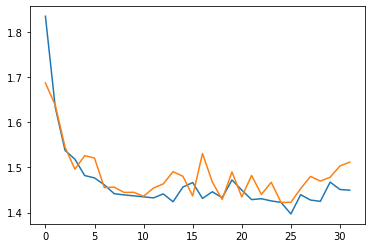

In [10]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show();

In [11]:
net = VisionTransformer()
net.load_state_dict(torch.load(PATH))
net.to(device);

In [12]:
net = net.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %
